In [1]:
%%bash

pip install getgist
getgist lambdaofgod github_topic_modeling_packages.sh -y
bash github_topic_modeling_packages.sh

  Fetching https://api.github.com/users/lambdaofgod/gists
  Reading https://gist.githubusercontent.com/lambdaofgod/c32ab43cecce4219a697376f3dda3866/raw/a618dbc45cf65020cf70be3c415ed075409071c7/github_topic_modeling_packages.sh
  Saving github_topic_modeling_packages.sh
  Done!
  Cloning https://github.com/lambdaofgod/mlutil to /tmp/pip-req-build-byxm7f3d
  Stored in directory: /tmp/pip-ephem-wheel-cache-ea9025ew/wheels/42/32/46/9616d5dd85e5dbc05ce3816dfa7dcedc052bc8b29442e1766a
Successfully built mlutil


In [2]:
import re
import tqdm
import requests

import numpy as np

from bs4 import BeautifulSoup
from markdown import markdown
import nltk


import pandas as pd
from pandas.io.json import json_normalize
from gensim import summarization

from sklearn import decomposition, feature_extraction, manifold
from sklearn.feature_extraction import stop_words
from sklearn import pipeline

import rank_bm25

from mlutil import topic_modeling

import seaborn as sns
import wordcloud

import matplotlib.pyplot as plt
from IPython.display import Markdown, display

/etc/miniconda/envs/ml/lib/python3.7/site-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.feature_extraction.stop_words module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.feature_extraction.text. Anything that cannot be imported from sklearn.feature_extraction.text is now part of the private API.
  warnings.warn(message, FutureWarning)
W0110 23:31:02.770780 139645199939392 __init__.py:56] Some hub symbols are not available because TensorFlow version is less than 1.14


In [3]:
plt.style.use('dark_background')

In [4]:
def printmd(string):
    display(Markdown(string))

In [5]:
def get_word_cloud(texts):
  text = ' '.join(texts)
  return wordcloud.WordCloud(max_font_size=40).generate(text)


def show_word_cloud(wc, figure_kwargs={'figsize': (8, 5)}):
  plt.figure(**figure_kwargs)
  plt.imshow(wc)
  plt.axis('off')
  plt.show()

  
def show_word_cloud_from_texts(text_column):
  texts = text_column.fillna('').values
  cloud = get_word_cloud(texts)
  show_word_cloud(cloud)

Put your Github token to `github_auth_key.txt`

You have to do this because, unfortunately, for now there is no way to use GraphQL without authentication.

In [6]:
key = open('github_auth_key.txt', 'r').read().strip()

Note that I barely know GraphQL: I made this query in [Github's API explorer](https://developer.github.com/v4/explorer/)

In [7]:
# An example to get the remaining rate limit using the Github GraphQL API.
headers = {'Authorization': 'token ' + key}


def run_query(query): # A simple function to use requests.post to make the API call. Note the json= section.
    request = requests.post('https://api.github.com/graphql', json={'query': query}, headers=headers)
    if request.status_code == 200:
        return request.json()
    else:
        raise Exception("Query failed to run by returning code of {}. {}".format(request.status_code, query))

        
# The GraphQL query (with a few aditional bits included) itself defined as a multi-line string.       
def get_next_paged_result(result):
  if result is None:
    end_cursor_string = ''
  else:
    end_cursor_string = 'after: "{}"'.format(result['data']['viewer']['starredRepositories']['pageInfo']['endCursor'])
  new_query_string = """{{
    viewer {{
      starredRepositories(first: 100, {}) {{
        pageInfo {{
          startCursor
          hasNextPage
          endCursor
        }}
        nodes {{
          name
          owner {{
            login
          }}
          description
          primaryLanguage {{
            name
          }}
          repositoryTopics(first: 10) {{
            nodes {{
              topic {{
                name
              }}
            }}
          }}
          object(expression: "master:README.md") {{
            ... on Blob {{
              text
            }}
          }}
        }}
      }}
    }}
  }}""".format(end_cursor_string)
  return run_query(new_query_string)

In [8]:
def get_starred_repo_information():
    next_result = None
    starred_repo_information = []
    for __ in tqdm.tqdm(range(5)):
      next_result = get_next_paged_result(next_result)
      starred_repo_information = starred_repo_information + next_result['data']['viewer']['starredRepositories']['nodes']
    return starred_repo_information

In [ ]:
starred_repo_information = get_starred_repo_information()

  0%|          | 0/5 [00:00<?, ?it/s]

In [ ]:
def get_cleaned_starred_repositories_df(repo_information, stemmer=nltk.stem.PorterStemmer()):
    repo_df = json_normalize(repo_information)
    repo_df.index = repo_df['name']
    repo_df.drop('name', axis=1, inplace=True)
    repo_df['primaryLanguage'] = repo_df['primaryLanguage.name']
    repo_df.drop('primaryLanguage.name', axis=1)
    repo_df['topics'] = repo_df['repositoryTopics.nodes'].apply(lambda recs: [r['topic']['name'] for r in recs])
    repo_df['topics'] = repo_df['topics'].apply(lambda ts: [stemmer.stem(t) for t in ts])
    repo_df['description'].fillna('', inplace=True)
    repo_df['description'] = repo_df['description'].apply(stemmer.stem)
    repo_df['description_keywords'] = repo_df['description'].apply(summarization.keywords)
    return repo_df

In [ ]:
def get_topic_representant_indices(topic_weights, topic_idx, num_representants=5):
    indices = topic_weights[:, topic_idx].argsort()[::-1]
    return indices[:num_representants]


def get_repos_representing_topic(repo_df, topic_weights, topic_idx, num_representants=5):
    return repo_df.iloc[get_topic_representant_indices(topic_weights, topic_idx, num_representants)]

In [ ]:
starred_repo_df = get_cleaned_starred_repositories_df(starred_repo_information)

Primary language

In [ ]:
starred_repo_df['primaryLanguage'].fillna('none/text').value_counts().plot.bar(rot=45);

In [ ]:
sns.distplot(starred_repo_df['description'].str.split().apply(lambda l: 0 if l is None else len(l)));

Topics word cloud

In [ ]:
show_word_cloud_from_texts(starred_repo_df['topics'].apply(' '.join))

Descriptions word cloud

In [ ]:
show_word_cloud_from_texts(starred_repo_df['description'])

In [ ]:
show_word_cloud_from_texts(starred_repo_df['description_keywords'])

## Topic modeling (repo descriptions)

In [ ]:
num_topics = 10
nmf = decomposition.NMF(n_components=num_topics)

In [ ]:
vectorizer = feature_extraction.text.TfidfVectorizer(
    stop_words=stop_words.ENGLISH_STOP_WORDS,
    ngram_range=(1,2)
)
description_vectors = vectorizer.fit_transform(starred_repo_df['description'])

In [ ]:
reduced_description_vectors = nmf.fit_transform(description_vectors)

In [ ]:
topic_words = topic_modeling.top_topic_words(nmf, vectorizer.get_feature_names(), 10)

In [ ]:
top_words_per_topic = [list(topic_words.iloc[topic].values) for topic in range(num_topics)]
representative_repos = [get_repos_representing_topic(starred_repo_df, reduced_description_vectors, topic)[['description']] for topic in range(num_topics)]

## Topic keywords and most representative repositories

In [ ]:
for topic in range(num_topics):
    printmd('## **topic {} keywords:**'.format(topic + 1))
    display(top_words_per_topic[topic])
    printmd('## **repositories representative for {}th topic:**'.format(topic + 1))
    display(representative_repos[topic])
    print()

## Visualizing repository 2D projection

In [ ]:
mds = manifold.MDS()
mds_reduced_vectors = mds.fit_transform(reduced_description_vectors)

In [75]:
representatives = pd.concat(representative_repos)

In [76]:
representative_indices = np.where(starred_repo_df.index.isin(representatives.index))

In [77]:
mds_reduced_representative_vectors = mds_reduced_vectors[representative_indices]

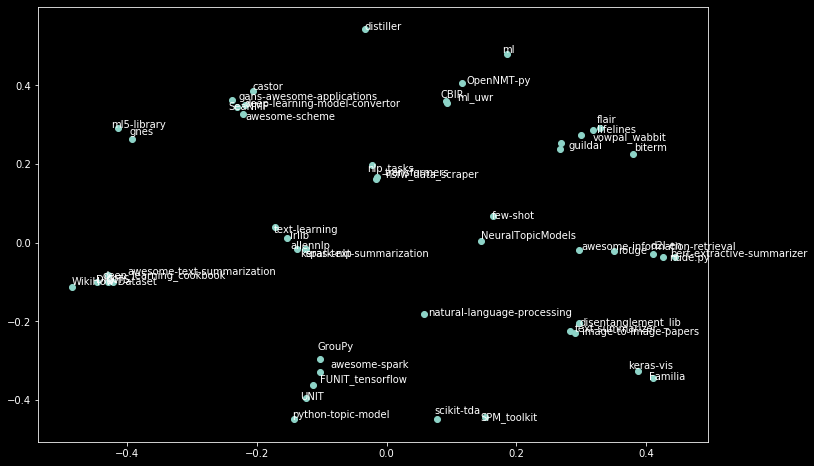

In [78]:
fig, ax = plt.subplots(figsize=(12, 8));

x, y = mds_reduced_representative_vectors[:, 0], mds_reduced_representative_vectors[:, 1]
ax.scatter(x, y)
for i, txt in enumerate(representatives.index):
    ax.annotate(txt, (x[i] + 0.01 * np.random.randn(), y[i] + 0.01 * np.random.randn()))

# Search

In [100]:
bm25 = rank_bm25.BM25Okapi(list(starred_repo_df['description'].str.split()))

In [179]:
def search_repos(query):
    scores = bm25.get_scores(query.split())
    #scores = scores[scores > 0]
    relevant_indices = np.argsort(-scores)[:100]
    return starred_repo_df.iloc[relevant_indices[scores[relevant_indices] > 0]]

In [180]:
search_repos('information retrieval')

,description,owner.login,primaryLanguage.name,repositoryTopics.nodes,object.text,primaryLanguage,object,topics,description_keywords
name,,,,,,,,,
irlib,information retrieval library (in python),gr33ndata,Python,[],NaN,Python,NaN,[],
awesome-information-retrieval,a curated list of awesome information retrieva...,harpribot,NaN,[],# Awesome Information Retrieval [![Awesome](ht...,NaN,NaN,[],retrieval
LIRE,open source library for content based image re...,dermotte,Java,"[{'topic': {'name': 'image-retrieval'}}, {'top...",# LIRE - Lucene Image Retrieval\nLIRE (Lucene ...,Java,NaN,"[image-retriev, lire, multimedia]",source
pytrec_eval,pytrec_eval is an information retrieval evalua...,cvangysel,C++,"[{'topic': {'name': 'information-retrieval'}},...",pytrec_eval\n===========\n\npytrec\_eval is a ...,C++,NaN,"[information-retriev, evalu]",retrieval
query-expansion,developing different methods for expanding a q...,phosseini,Python,[],# query-expansion\n\nThis repository is dedica...,Python,NaN,[],different\nquery
SERT,semantic entity retrieval toolkit,cvangysel,Python,[{'topic': {'name': 'representation-learning'}...,Semantic Entity Retrieval Toolkit\n===========...,Python,NaN,"[representation-learn, deeplearn, neural-netwo...",
dit,python package for information theory.,dit,Python,"[{'topic': {'name': 'python'}}, {'topic': {'na...",NaN,Python,NaN,"[python, information-theori]",
ir-python,a python implementation for information retrie...,zxzlogic,Python,[],# ir-python\nA python implementation for infor...,Python,NaN,[],retrieval\npython\nindex\nindexing
cnnimageretrieval-pytorch,cnn image retrieval in pytorch: training and e...,filipradenovic,Python,"[{'topic': {'name': 'image-retrieval'}}, {'top...",## CNN Image Retrieval in PyTorch: Training an...,Python,NaN,"[image-retriev, convolutional-neural-network, ...",cnn\ncnns
